# Natural Language Processing: Job Market Description Clusters

In this notebook, we examine the data science internships collected from linkedin and attempt to create word embeddings to measure the similarity between each clusters. In doing so, we could potentially find patterns in how or why some of the jobs are clustered together, potentially indicating the type of data science jobs that they represent

## Workflow:
1. Clean, filter, and pre-process textual data
2. Employ embedding model map sentences & paragraphs to a 384 dimensional dense vector space and so that it can be used for tasks like clustering or semantic search.
3. Perform dimensionality reduction with UMAP to 5 dimensions for better clustering quality
4. Perform clustering with Hierarchical Density-Based Spatial Clustering of Applications with Noise (HDBSCAN), an unsupervised method to auto-find best fit clusters
5. Extract top keywords from those clusters and Employ a LLM (GPT 4o mini) to semantically assign a label to each clusters based on the top occurring keywords in each cluster
6. Visualize the clusters again each with a colored label to find insights about the 'sub-functions' of data science roles (or more specifically internships) in the data science job market.

In [2]:
!pip install supabase

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.5/48.5 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 730.0/730.0 kB 50.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 105.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.9/123.9 kB 17.0 MB/s eta 0:00:00
  Attempting uninstall: cachetools
    Found existing installation: cachetools 7.0.1
    Uninstalling cachetools-7.0.1:
      Successfully uninstalled cachetools-7.0.1


## Importing Data and inspecting the table

In [3]:
import os
import pandas as pd
from pathlib import Path
from supabase import create_client
from google.colab import userdata

# Fetch secrets directly from Colab UserData
url = userdata.get('SUPABASE_PROJECT_URL')
key = userdata.get('SUPABASE_SECRET_KEY')

supabase = create_client(url, key)

all_data = []
start = 0

while True:
    # get 1000 rows at a time
    response = supabase.table("job-market-stream").select("*").range(start, start + 999).execute()

    # stop if no more data
    if not response.data:
        break

    # add to list
    all_data.extend(response.data)
    print("downloaded", len(all_data), "rows")

    # stop if got only less than 1000 rows
    if len(response.data) < 1000:
        break

    # get next batch
    start += 1000

df = pd.DataFrame(all_data)
df.to_csv("job-market-stream_export.csv", index=False)
print("saved to job-market-stream_export.csv")

downloaded 1000 rows
downloaded 2000 rows
downloaded 3000 rows
downloaded 4000 rows
downloaded 5000 rows
downloaded 6000 rows
downloaded 7000 rows
downloaded 8000 rows
downloaded 9000 rows
downloaded 10000 rows
downloaded 11000 rows
downloaded 12000 rows
downloaded 13000 rows
downloaded 14000 rows
downloaded 15000 rows
downloaded 16000 rows
downloaded 17000 rows
downloaded 18000 rows
downloaded 19000 rows
downloaded 20000 rows
downloaded 21000 rows
downloaded 22000 rows
downloaded 23000 rows
downloaded 24000 rows
downloaded 25000 rows
downloaded 25685 rows
saved to job-market-stream_export.csv


In [4]:
# sort by time posted
df = df.sort_values(by="time_posted_parsed", ascending=False)
print(df.shape)
df.head(5)

(25685, 18)


,job_id,job_title,job_description,company_name,location,job_function,skills,degree_requirement,time_posted_parsed,application_link,num_applicants_int,work_mode,scraped_at,created_at,latitude,longitude,industry,visa_sponsorship
10077,4373005861,Biostatistics Intern,Pay found in job postRetrieved from the descri...,Corcept Therapeutics,"Redwood City, CA",Data Scientist,"Python, R, SAS, Communication, Problem Solving",PhD,2026-02-17T18:47:41.611865+00:00,https://www.linkedin.com/signup/cold-join?sour...,25.0,On-site,2026-02-17T18:52:43.939318+00:00,2026-02-17T18:56:29.075606,37.486324,-122.232523,Other,Unclear
10072,4374107835,Data Analyst,Aditi Consulting provided pay rangeThis range ...,Aditi Consulting,"Georgia, United States",Data Analyst / BI,"Excel, Communication, Presentation",None,2026-02-17T18:47:36.887225+00:00,https://www.linkedin.com/jobs/view/4374107835,25.0,On-site,2026-02-17T18:52:37.324968+00:00,2026-02-17T18:56:29.075606,NaN,NaN,Other,Unclear
10071,4374110919,Data Analyst Intern,Pay found in job postRetrieved from the descri...,The Mutual Group,Des Moines Metropolitan Area,Data Engineer,"SQL, Excel",None,2026-02-17T18:41:36.098309+00:00,https://www.linkedin.com/signup/cold-join?sour...,25.0,Hybrid,2026-02-17T18:52:36.612887+00:00,2026-02-17T18:56:29.075606,NaN,NaN,Other,Unclear
10069,4374110905,"Intern, Vehicle Integration Electrical Enginee...","About SlateAt Slate, we’re building safe, reli...",Slate Auto,"Troy, MI",Software Engineer,None,None,2026-02-17T18:39:31.721931+00:00,https://www.linkedin.com/jobs/view/externalApp...,25.0,On-site,2026-02-17T18:52:33.703758+00:00,2026-02-17T18:56:29.075606,42.605589,-83.149930,Other,Unclear
10068,4364789383,Procurement Intern,Employment Type:InternshipCompensation: $26.5 ...,RoboStruct Technologies,"New York, NY",Data Analyst / BI,"Excel, PowerPoint",None,2026-02-17T18:35:31.639478+00:00,https://www.linkedin.com/jobs/view/4364789383,25.0,On-site,2026-02-17T18:52:31.639497+00:00,2026-02-17T18:56:29.075606,40.712728,-74.006015,Tech - Startup,Unclear


## Preprocessing: Finding Actual Data Science Jobs
- Filtering by job title to find roles that actually correspond to a data science role

- Preliminary search of the types of jobs that exist in the database

In [5]:
# look at the general categories
print(df.value_counts('job_title'))

# look at the top reoccuring job titles
print(f'\n{df['job_title'].value_counts().head(50)}')


job_title
Data Analyst Intern                                327
Data Science Intern                                283
IT Data Analytics Intern                           234
IT Data Analytics Intern (REMOTE)                  198
Data Analytics Intern                              192
                                                  ... 
Youth Leadership Academy Student Intern              1
[2026] Data Scientist - PhD Intern (Short Term)      1
[Fall 2025] Robotics Intern                          1
[Summer 2026] Behavioral Health Internship           1
[Summer 2026] Data Research Internship               1
Name: count, Length: 6824, dtype: int64

job_title
Data Analyst Intern                                                                                        327
Data Science Intern                                                                                        283
IT Data Analytics Intern                                                                                   234
I

- narrowing down the search space with keyword searching

In [6]:
target_keywords = ['data scientist', 'ml engineer', 'machine learning', 'data analyst',
                   'data engineer', 'analytics engineer', 'ai engineer', 'nlp engineer',
                   'data', 'marketing analytics', 'analytics', 'business analytics', 'research',
                   'research scientist', 'business intelligence']

# filter for data roles by keywords
mask = df['job_title'].str.lower().str.contains('|'.join(target_keywords), na=False, regex=True)
df_filtered = df[mask].copy()

print(f"\nFiltered dataset shape: {df_filtered.shape}")
print(f"Percentage of data retained: {len(df_filtered)/len(df)*100:.1f}%")
print(f"\nSample of filtered titles:")
print(df_filtered['job_title'].value_counts().head(20))
print(f'\ntotal number of data jobs available for analysis & clustering: {df_filtered.shape[0]}')


Filtered dataset shape: (9436, 18)
Percentage of data retained: 36.7%

Sample of filtered titles:
job_title
Data Analyst Intern                                                                                        327
Data Science Intern                                                                                        283
IT Data Analytics Intern                                                                                   234
IT Data Analytics Intern (REMOTE)                                                                          198
Data Analytics Intern                                                                                      192
Data Engineering Intern                                                                                    130
Machine Learning Intern - Summer 2026                                                                      113
Data Engineer Intern                                                                                       104
Dat

- finding top reoccurring words in each descriptions (potentially removing some of those words due to irrelevancy)

In [9]:
from collections import Counter

# Extract all words from job descriptions
all_words = []
for desc in df_filtered['job_description']:
    all_words.extend(desc.lower().split())

# Find most common words
word_freq = Counter(all_words)
most_common = word_freq.most_common(200)

print("Top 50 most common words across all descriptions:")
for word, count in most_common[:50]:
    print(f"{word}: {count}")

Top 50 most common words across all descriptions:
and: 137716
to: 77647
the: 62145
data: 51439
in: 48788
a: 44400
of: 43643
or: 34125
with: 32971
for: 29734
is: 22118
our: 16903
you: 16464
will: 16418
on: 15756
at: 12716
be: 12439
we: 12350
your: 12194
this: 12016
as: 11961
are: 11956
work: 11844
by: 11589
that: 11555
an: 11109
business: 9339
experience: 7995
science,: 7581
intern: 7329
internship: 7183
from: 7012
team: 6947
related: 6945
analytics: 6838
support: 6633
information: 6195
not: 6083
job: 5985
computer: 5758
who: 5632
analysis,: 5361
have: 5131
other: 5124
machine: 5047
role: 5032
all: 5012
&: 4975
power: 4927
pay: 4871


- Removing missing descriptions

In [10]:
import re

def clean_job_description(text):
    if pd.isna(text):
        return ""

    # Remove common boilerplate sections (case insensitive)
    boilerplate_patterns = [
        # Job board artifacts
        r'show more.*?show less',
        r'seniority level.*?industries',
        r'referrals increase.*',
        r'powered by.*',
        r'see who you know.*',

        # Legal/compliance
        r'equal employment.*?laws\.?',
        r'we (provide|offer) equal.*?laws\.?',
        r'the company provides equal.*?training\.?',
        r'this policy applies.*?training\.?',

        # Physical requirements
        r'physical (demands|requirements).*?(printers|equipment)\.?',
        r'ability to (sit|stand|lift).*?\.?',

        # Working conditions
        r'working conditions.*',

        # Benefits (generic)
        r'benefits:.*?(first year|annually)\.?',
        r'major medical.*?first year\.?',

        # Company marketing
        r'recognized as one of.*?work',
        r'fortune magazine.*?work',

        # Compensation
        r'compensation.*?\$[\d\.,]+.*?workweek\.?',
        r'base pay.*?\$[\d\.,]+',
        r'salary range.*?\$[\d\.,]+',
        r'hourly rate.*?\$[\d\.,]+',
        r'salary:.*?[\d\.,\$]+',
    ]

    for pattern in boilerplate_patterns:
        text = re.sub(pattern, '', text, flags=re.IGNORECASE | re.DOTALL)

    # Remove URLs
    text = re.sub(r'http[s]?://\S+|www\.\S+', '', text)

    # Remove email addresses
    text = re.sub(r'\S+@\S+', '', text)

    # Remove HTML tags
    text = re.sub(r'<[^>]+>', '', text)

    # Remove checkboxes and form field markers
    text = re.sub(r'[☐☒☑✓✗×]', '', text)
    text = re.sub(r'(reports? to|department|supervisory responsibility|position type|exemption status|travel required|license\(s\) required):.*?\n', '', text, flags=re.IGNORECASE)

    # Remove salary placeholders
    text = re.sub(r'[\.\$]*/?(yr|year|hr|hour)\s*-\s*[\.\$]*/?(yr|year|hr|hour)', '', text)

    # Remove monetary amounts
    text = re.sub(r'\$?[\d,\.]+\s*/?\s*(yr|year|hr|hour|annually)?', '', text)

    # Remove standalone numbers
    text = re.sub(r'\b\d+\b(?!\s*[a-zA-Z])', '', text)

    # Remove percentages in isolation
    text = re.sub(r'\(\s*%\s*\)', '', text)

    # Remove extra whitespace, newlines, tabs
    text = re.sub(r'\s+', ' ', text).strip()

    # remove a reoccuring phrase:
    text = re.sub(r'Pay found in job postRetrieved from the description', '', text)

    return text

df_filtered['cleaned_description'] = df_filtered['job_description'].apply(clean_job_description)

print("\nBefore cleaning text")
print(df_filtered['job_description'].iloc[0])
print("\nAfter cleaning text")
print(df_filtered['cleaned_description'].iloc[0])


Before cleaning text
Aditi Consulting provided pay rangeThis range is provided by Aditi Consulting. Your actual pay will be based on your skills and experience — talk with your recruiter to learn more.Base pay range$60.00/hr - $63.00/hrPayrate:$60.00 - $63.00/hr.Summary:Employee Success (ES) is made up of human resources (HR) professionals who come together to continue to build with a goal of helping our employees do the best work of their lives. In Employee Success, we attract and retain the top talent critical to building out our organization. Whether we are recruiting the next excellent candidate for our company, building out new programs, or refining our current operations, Employee Success is passionate about the design, development and delivery of outstanding employee experience, which allows to deliver a best-in-class customer experience in the market. Within ES, the Agentic Talent Experience team is seeking a driven, analytical and highly skilled professional to fill our Data 

- remove irrelevant words in job descriptions

In [11]:
# inspect a typical job description
print(df_filtered['job_description'].iloc[2])
# Remove words like Pay found in job postRetrieved from the description
df_filtered['cleaned_description'] = df_filtered['job_description'].str.replace(r'\bPay found in job postRetrieved from the description.\b', '', regex=True)
print(f'\nAfter removing irrelevant words: {df_filtered['cleaned_description'].iloc[2]}')

Pay found in job postRetrieved from the description.Base pay range$25.72/hr - $38.41/hrAt Dow, we believe in putting people first and we’re passionate about delivering integrity, respect and safety to our customers, our employees and the planet.Our people are at the heart of our solutions. They reflect the communities we live in and the world where we do business. Their diversity is our strength. We’re a community of relentless problem solvers that offers the daily opportunity to contribute with your perspective, transform industries and shape the future. Our purpose is simple - to deliver a sustainable future for the world through science and collaboration. If you’re looking for a challenge and meaningful role, you’re in the right place.Dow has a Data Engineering Internship opportunity within Dow's Enterprise Data & Analytics organization.This position is an in-person, full-time internship role based out of Champaign, IL at the Dow Delivery Center at UIUC (University of Illinois Urban

# Filter data after December 1st

In [12]:
# Convert to datetime format
df_filtered['time_posted_parsed'] = pd.to_datetime(df_filtered['time_posted_parsed'], errors='coerce')

# Get the min and max dates
min_date = df_filtered['time_posted_parsed'].min()
max_date = df_filtered['time_posted_parsed'].max()

print(f"Date Range: {min_date} to {max_date}\ntotal number of viable data: {len(df_filtered)}")

df_filtered.to_csv('data_jobs_filtered.csv', index=False)

Date Range: 2025-12-02 06:39:42.549738+00:00 to 2026-02-17 18:47:36.887225+00:00
total number of viable data: 9436


## Job Description embedding

- use an existing embedding model to embed and tokenize all job descriptions

In [13]:
from sentence_transformers import SentenceTransformer
import numpy as np
import torch
# use gpu to accelerate the process
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SentenceTransformer('all-MiniLM-L6-v2', device=device)

# generate embeddings for descriptions
descriptions = df_filtered['cleaned_description'].tolist()

print(f'encoding {len(descriptions)} job descriptions')
embeddings = model.encode(descriptions, show_progress_bar=True, batch_size = 64)
print(f'\nEmbeddings shape: {embeddings.shape}')
print(f'Each description is represented by {embeddings.shape[1]} dimensions')


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/103 [00:00<?, ?it/s]

BertModel LOAD REPORT from: sentence-transformers/all-MiniLM-L6-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

encoding 9436 job descriptions


Batches:   0%|          | 0/148 [00:00<?, ?it/s]


Embeddings shape: (9436, 384)
Each description is represented by 384 dimensions


- quickly inspect a typical embedding of a description to see if we're embedding them correctly
- inspecting how our sentence transformer model tokenizes each word/characters

In [14]:
embedding_idx = 0
example_text = descriptions[embedding_idx]
example_embedding = embeddings[embedding_idx]

print(f'ORIGINAL TEXT:')
print(f'{example_text[:500]}')

print(f'\nTOKENIZATION OUTLOOK:')
tokens = model.tokenizer.tokenize(example_text)
print(f'number o tokens {len(tokens)}')
print(f'first 50 tokenized words: {tokens[:50]}')

print(f'\nEMBEDDING VECTOR:')
print(f"Shape: {example_embedding.shape}")
print(f"First 10 values: {example_embedding[:10]}")
print(f"Min value: {example_embedding.min():.4f}")
print(f"Max value: {example_embedding.max():.4f}")
print(f"Mean value: {example_embedding.mean():.4f}")

Token indices sequence length is longer than the specified maximum sequence length for this model (1141 > 256). Running this sequence through the model will result in indexing errors


ORIGINAL TEXT:
Aditi Consulting provided pay rangeThis range is provided by Aditi Consulting. Your actual pay will be based on your skills and experience — talk with your recruiter to learn more.Base pay range$60.00/hr - $63.00/hrPayrate:$60.00 - $63.00/hr.Summary:Employee Success (ES) is made up of human resources (HR) professionals who come together to continue to build with a goal of helping our employees do the best work of their lives. In Employee Success, we attract and retain the top talent critical to 

TOKENIZATION OUTLOOK:
number o tokens 1141
first 50 tokenized words: ['adi', '##ti', 'consulting', 'provided', 'pay', 'range', '##thi', '##s', 'range', 'is', 'provided', 'by', 'adi', '##ti', 'consulting', '.', 'your', 'actual', 'pay', 'will', 'be', 'based', 'on', 'your', 'skills', 'and', 'experience', '—', 'talk', 'with', 'your', 'recruit', '##er', 'to', 'learn', 'more', '.', 'base', 'pay', 'range', '$', '60', '.', '00', '/', 'hr', '-', '$', '63', '.']

EMBEDDING VECTOR:
Shape: 

- check how similar two descrpitions are with cosine similarity (evaluate whether we should use this for clustering)

In [15]:
from sklearn.metrics.pairwise import cosine_similarity

# Compare first two descriptions
sim = cosine_similarity([embeddings[0]], [embeddings[1]])[0][0]
print(f"Similarity between job 0 and job 1: {sim:.4f}")
print(f"Job 0 title: {df_filtered['job_title'].iloc[0]}")
print(f"Job 1 title: {df_filtered['job_title'].iloc[1]}")

# compare next two descrpitions
sim = cosine_similarity([embeddings[2]], [embeddings[3]])[0][0]
print(f"\nSimilarity between job 2 and job 3: {sim:.4f}")
print(f"Job 2 title: {df_filtered['job_title'].iloc[2]}")
print(f"Job 3 title: {df_filtered['job_title'].iloc[3]}")

# Compare a description to itself
self_sim = cosine_similarity([embeddings[0]], [embeddings[0]])[0][0]
print(f"\nSimilarity of a description with itself: {self_sim:.4f}")

Similarity between job 0 and job 1: 0.5983
Job 0 title: Data Analyst
Job 1 title: Data Analyst Intern

Similarity between job 2 and job 3: 0.6707
Job 2 title: Data Engineer Internship Summer 2026 at the Dow Delivery Center at UIUC (Champaign, IL)
Job 3 title: Data Analyst Intern

Similarity of a description with itself: 1.0000


- visualize similar embeddings and different embeddings and see how their relationships look like in a heatmap

In [16]:
sample_embeddings = embeddings[:24]
sim_matrix = cosine_similarity(sample_embeddings)

# zero out the diagonal
np.fill_diagonal(sim_matrix, 0)

# finding the top 5 most similar pairs
pairs = []
for i in range(24):
  for j in range(i+1, 24):
    pairs.append({
        'i': i,
        'j': j,
        'similarity': sim_matrix[i][j],
        'title_i': df_filtered['job_title'].iloc[i],
        'title_j': df_filtered['job_title'].iloc[j],
    })
pairs = sorted(pairs, key=lambda x: x['similarity'], reverse=True)
print('TOP 5 MOST similar job pairs')
for p in pairs[:5]:
    print(f"\nSimilarity: {p['similarity']:.4f}")
    print(f"Job {p['i']}: {p['title_i']}")
    print(f"Job {p['j']}: {p['title_j']}")

print("\nTOP 5 LEAST similar job pairs")
for p in pairs[-5:]:
    print(f"\nSimilarity: {p['similarity']:.4f}")
    print(f"Job {p['i']}: {p['title_i']}")
    print(f"Job {p['j']}: {p['title_j']}")

TOP 5 MOST similar job pairs

Similarity: 1.0000
Job 13: Business Intelligence Intern
Job 14: Business Intelligence Intern

Similarity: 0.9641
Job 2: Data Engineer Internship Summer 2026 at the Dow Delivery Center at UIUC (Champaign, IL)
Job 5: Data Platform Engineer Internship Summer 2026 at the Dow Delivery Center at UIUC (Champaign, IL)

Similarity: 0.7253
Job 1: Data Analyst Intern
Job 2: Data Engineer Internship Summer 2026 at the Dow Delivery Center at UIUC (Champaign, IL)

Similarity: 0.7019
Job 1: Data Analyst Intern
Job 5: Data Platform Engineer Internship Summer 2026 at the Dow Delivery Center at UIUC (Champaign, IL)

Similarity: 0.6953
Job 0: Data Analyst
Job 10: Human Resources Analytics Specialist

TOP 5 LEAST similar job pairs

Similarity: 0.1204
Job 11: National Data Services Intern
Job 14: Business Intelligence Intern

Similarity: 0.0985
Job 0: Data Analyst
Job 18: Education Data Intern/Education Survey Data 2026 Summer Intern-Washington, DC

Similarity: 0.0804
Job 4: D

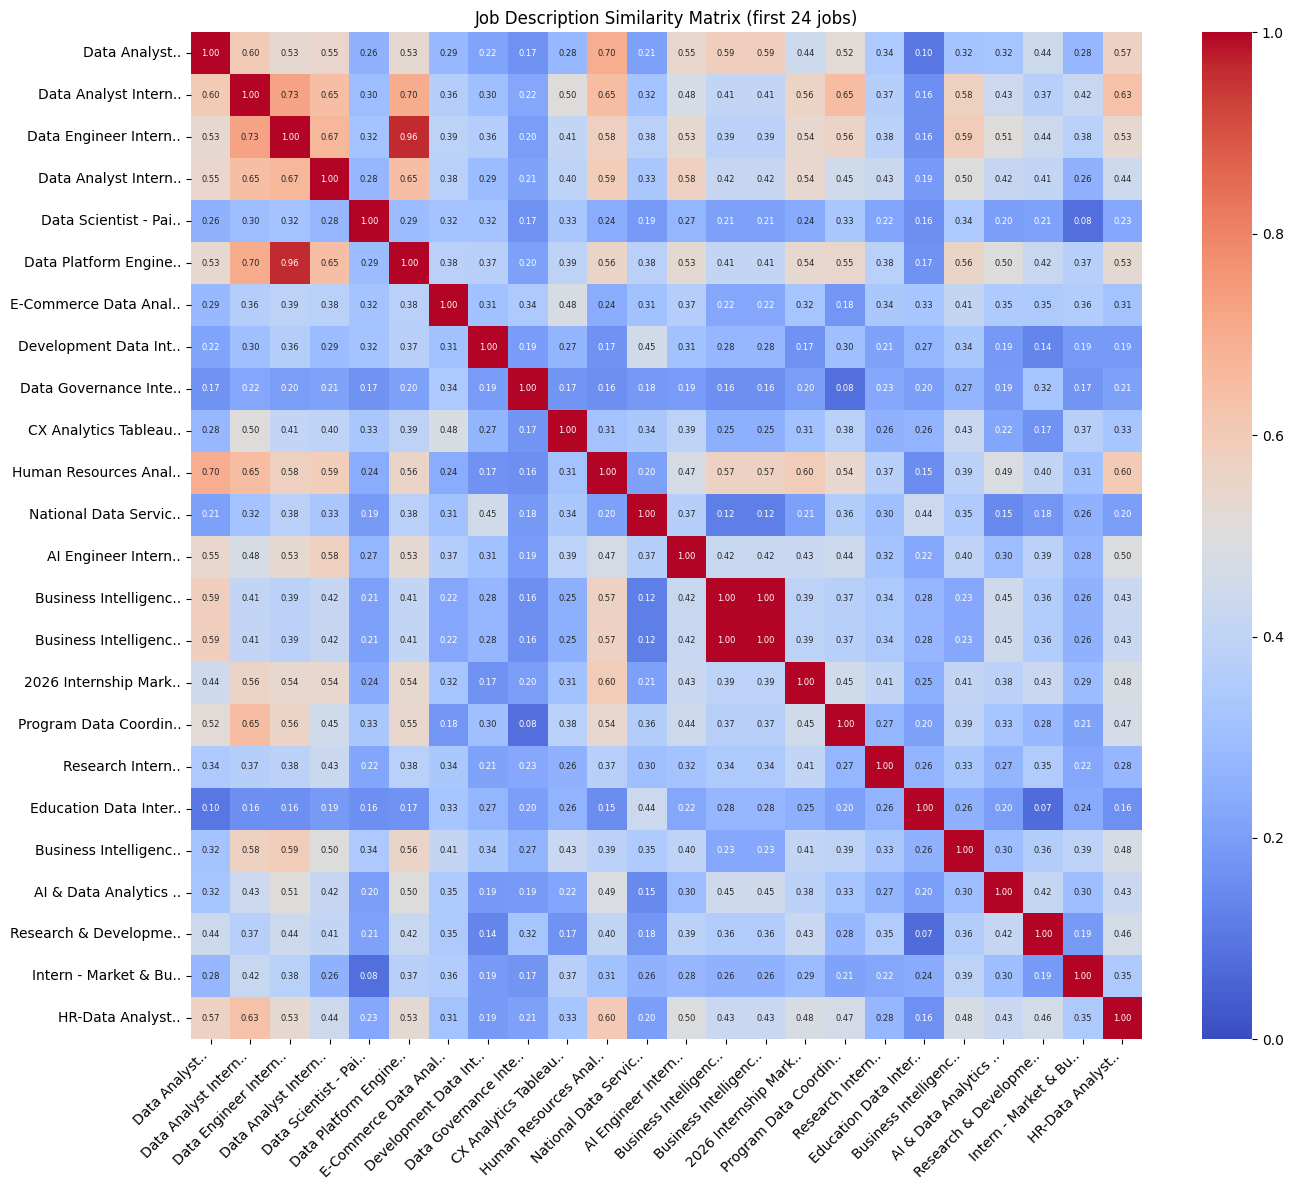

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

# shortening titles for display
np.fill_diagonal(sim_matrix, 1)
labels = [df_filtered['job_title'].iloc[i][:20] + '..' for i in range(24)]

plt.figure(figsize=(14, 12))
sns.heatmap(sim_matrix,
            xticklabels=labels,
            yticklabels=labels,
            cmap='coolwarm',
            vmin=0, vmax=1,
            annot=True, fmt='.2f', annot_kws={'size': 6})
plt.title("Job Description Similarity Matrix (first 24 jobs)")
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

# Dimensionality Reduction
- utilizing UMAP to compress the 384 dimension embedding to a lower dimension so clustering models can work more effectively

In [18]:
import umap
umap_model = umap.UMAP(
    n_components=5, # compress down to 5 dimensions
    n_neighbors=100,
    min_dist=0, # setting to 0 to tightly pack the data points
    metric='cosine', # again using cosine distance,
    init='random',
    random_state=42
)

reduced_embeddings = umap_model.fit_transform(embeddings)
print(f'original embedding shape: {embeddings.shape}')
print(f'reduced embedding shape: {reduced_embeddings.shape}')

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


original embedding shape: (9436, 384)
reduced embedding shape: (9436, 5)


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


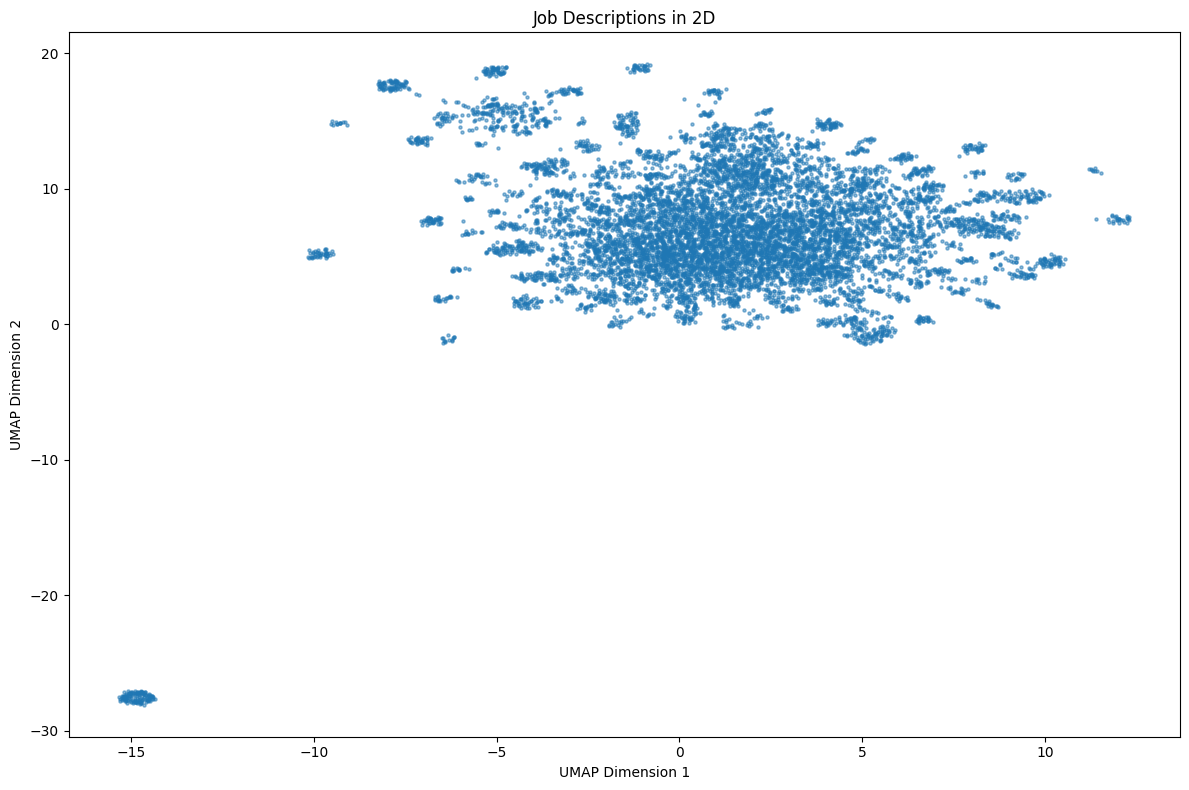

In [19]:
# visualize the reduced data points
# fit a separate 2D umap just for visualization
umap_2d = umap.UMAP(
    n_components=2,
    n_neighbors=100, # increase neighbors to produce more distinct visual clusters
    min_dist=0.9, # same for increasing minimal distances between data points
    metric='cosine',
    init='random',
    random_state=42
)

embeddings_2d = umap_2d.fit_transform(embeddings)

plt.figure(figsize=(12, 8))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], s=5, alpha=0.5)
plt.title("Job Descriptions in 2D")
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.tight_layout()
plt.show()

# HDBSCAN Clustering
- using a density based clustering model to automatically discover clusters by finding dense regions of data points.

In [20]:
import hdbscan
cluster_model = hdbscan.HDBSCAN(
    min_cluster_size=100, # defining the minimum num of jobs needed to form a cluster
    min_samples=2,  # controls how much samples need to exist can be declared as a dense region by HDBSCAN
    metric='euclidean', # euclidean distances may work better
    cluster_selection_method='leaf' # finds more balanced clusters
)

cluster_labels = cluster_model.fit_predict(reduced_embeddings)

# inspect results
n_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
# calculate number of unclustered jobs (umap labels noise as -1)
n_noise = (cluster_labels == -1).sum()
print(f'number of clusters found: {n_clusters}')
print(f'number unclustered jobs: {n_noise} (about {n_noise/len(cluster_labels)*100:.1f}%)')
print(f'\nCluster sizes:\n')
for label in sorted(set(cluster_labels)):
  count = (cluster_labels == label).sum()
  name = "Noise Cluster" if label == -1 else f'Cluster {label}'
  print(f'{name}: {count} jobs')


/usr/local/lib/python3.12/dist-packages/hdbscan/robust_single_linkage_.py:175: SyntaxWarning: invalid escape sequence '\{'
  $max \{ core_k(a), core_k(b), 1/\alpha d(a,b) \}$.


number of clusters found: 26
number unclustered jobs: 3824 (about 40.5%)

Cluster sizes:

Noise Cluster: 3824 jobs
Cluster 0: 122 jobs
Cluster 1: 130 jobs
Cluster 2: 317 jobs
Cluster 3: 235 jobs
Cluster 4: 108 jobs
Cluster 5: 145 jobs
Cluster 6: 141 jobs
Cluster 7: 119 jobs
Cluster 8: 106 jobs
Cluster 9: 100 jobs
Cluster 10: 102 jobs
Cluster 11: 107 jobs
Cluster 12: 140 jobs
Cluster 13: 227 jobs
Cluster 14: 237 jobs
Cluster 15: 151 jobs
Cluster 16: 214 jobs
Cluster 17: 663 jobs
Cluster 18: 241 jobs
Cluster 19: 304 jobs
Cluster 20: 423 jobs
Cluster 21: 211 jobs
Cluster 22: 101 jobs
Cluster 23: 188 jobs
Cluster 24: 399 jobs
Cluster 25: 381 jobs


# Extracting keywords from each cluster with TF-IDF
- term frequency: how often a word appears in a document
- inverse document frequency: how rare that word is across all documents

In [21]:
!pip install bertopic

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.7/154.7 kB 14.6 MB/s eta 0:00:00


In [22]:
from sklearn.feature_extraction.text import CountVectorizer
# define a class based tf_idf function that calculate tf-idf scores for each cluster
# this suits our case as each cluster is a document, rather than each job description
def c_tf_idf(documents, m, ngram_range=(1, 2)):
    # create vocabulary of all words/phrases
    # 1 word and 2 word phrases
    count = CountVectorizer(ngram_range=ngram_range, stop_words="english").fit(documents)

    # define a word count matrix
    # where rows=clusters, columns=words, values=word counts
    t = count.transform(documents).toarray()

    # total words in each cluster
    total_words = t.sum(axis=1)

    # term frequency calculation
    # the number shows what % of cluster's words is a word
    tf = np.divide(t.T, total_words)

    # calculate how many times each word appears across all clusters
    sum_t = t.sum(axis=0)

    # inverse document frequency caluclation
    # finds whether a word is rare or common across clusters
    idf = np.log(np.divide(m, sum_t)).reshape(-1, 1)

    # final tf-idf score
    tf_idf = np.multiply(tf, idf)
    return tf_idf, count

# Prepare documents per cluster
docs_per_cluster = []
for cluster_id in sorted(set(cluster_labels)):
    if cluster_id == -1:  # skip unclustered data
        continue
    cluster_docs = df_filtered[cluster_labels == cluster_id]['cleaned_description'].tolist()
    docs_per_cluster.append(" ".join(cluster_docs))

# Calculate tf-idf score
tf_idf, count = c_tf_idf(docs_per_cluster, m=len(docs_per_cluster))

# Extract top 10 keywords per cluster
def extract_top_n_words_per_topic(tf_idf, count, n=10):
    words = count.get_feature_names_out()
    labels = list(range(len(docs_per_cluster)))
    tf_idf_transposed = tf_idf.T
    indices = tf_idf_transposed.argsort()[:, -n:]
    top_n_words = {label: [(words[j], tf_idf_transposed[i][j]) for j in indices[i]][::-1] for i, label in enumerate(labels)}
    return top_n_words

top_n_words = extract_top_n_words_per_topic(tf_idf, count, n=10)

print("Top occurring keywords per cluster:\n")
for cluster_id in sorted(set(cluster_labels)):
    if cluster_id == -1:
        continue
    cluster_size = (cluster_labels == cluster_id).sum()
    actual_cluster_idx = list(sorted(set(cluster_labels)))[cluster_id + 1]  # adjust for -1 noise
    print(f"Cluster {cluster_id} ({cluster_size} jobs):")
    words = [word for word, score in top_n_words[cluster_id]]
    print(f"  {', '.join(words)}\n")

Top occurring keywords per cluster:

Cluster 0 (122 jobs):
  00, ﬁeld kinesiology, ﬁeld, últimos dias, últimos, zyndra talent, zyndra, zum standortmolly, zum, zuckerberg san

Cluster 1 (130 jobs):
  aumovio, unwanted, way home, comcast spectacor, spectacor, glass, expert guidance, crm product, wattpad, worldclass

Cluster 2 (317 jobs):
  examining firm, connected customers, specific use, transform cisco, customers harness, collar, collar fraud, hudson gas, college currently, college years

Cluster 3 (235 jobs):
  person software, ai pwc, intern mountain, field 3rd, nlp projects, security pwc, assurance testing, mining pwc, usage quality, manipulation algorithm

Cluster 4 (108 jobs):
  material industrial, program chemistry, fundamental applied, solve chemical, mechanical biomedical, value orientation, dow facilities, positions identified, billion 2023, abilities technical

Cluster 5 (145 jobs):
  manufacturing production, industrial mechanical, building science, fea simulations, analyt

# Insights extraction via Language Models
- using a LLM to identify each clusters' labels

In [36]:
from google.colab import userdata
from openai import OpenAI
import json
import re

openai_api = userdata.get('OPENAI_API_KEY')
client = OpenAI(api_key=openai_api)

cluster_keywords = {}
# data preparation
for cluster_id in sorted(set(cluster_labels)):
    if cluster_id == -1:
        continue
    cluster_size = (cluster_labels == cluster_id).sum()
    words = [word for word, score in top_n_words[cluster_id]]
    cluster_keywords[cluster_id] = {
        'size': cluster_size,
        'keywords': words[:50]
    }

prompt = """You are analyzing job market data for data science roles. Below are 24 clusters of job descriptions, each with their top distinguishing keywords and the number of jobs in that cluster.

Your task: Assign a concise, descriptive label to each cluster that best captures the sub-job-function it represents (e.g., "Machine Learning Engineer - NLP", "Human Resource Data Science", "Market Research Analytics Engineer", etc.).

Return your response as a valid JSON object mapping cluster IDs to labels.

You MUST create labels that ACTUALLY exist in the market, don't invent RANDOM labels that don't exist.

Create labels for industry and job function, don't create labels for interns

Here are the clusters:"""

for cluster_id, data in cluster_keywords.items():
    prompt += f'\nCluster {cluster_id} ({data["size"]} jobs):\n'
    prompt += f'Keywords: {", ".join(data["keywords"])}\n'

prompt += "\n\nReturn ONLY the JSON object, no other text."

response = client.chat.completions.create(
    model="gpt-4o-mini",
    messages=[
        {"role": "system", "content": "You are a data science job market analyst who creates clear, concise labels that actually exists in the market."},
        {"role": "user", "content": prompt}
    ],
    temperature=0.3
)

response_text = response.choices[0].message.content
print("\nGPT Output:")
print(response_text)

# extract JSON and handle markdown formatting
try:
    # strip markdown code blocks if present
    clean_json = re.sub(r'^```json\s*|```$', '', response_text.strip(), flags=re.MULTILINE)
    cluster_names = json.loads(clean_json)
    # convert string keys to integers
    cluster_names = {int(k): v for k, v in cluster_names.items()}

    print("\nGenerated Cluster Names:")
    for cluster_id, name in sorted(cluster_names.items()):
        print(f"Cluster {cluster_id}: {name}")

except Exception as e:
    print(f"Error parsing JSON: {e}")
    print("Raw Response:")
    print(response_text)


GPT Output:
```json
{
    "0": "Kinesiology Data Analyst",
    "1": "CRM Data Analyst",
    "2": "Customer Insights Analyst",
    "3": "NLP Data Scientist",
    "4": "Chemical Engineering Data Analyst",
    "5": "Manufacturing Data Analyst",
    "6": "Data Analyst - Causal Inference",
    "7": "Data Engineer - ETL",
    "8": "Sports Analytics Data Scientist",
    "9": "Healthcare Data Analyst",
    "10": "Machine Learning Engineer - Neural Networks",
    "11": "ETL Developer",
    "12": "Urban Data Analyst",
    "13": "Healthcare Data Analyst - EHR",
    "14": "Health Operations Analyst",
    "15": "Logistics Data Analyst",
    "16": "Healthcare Analytics Consultant",
    "17": "Healthcare Data Scientist",
    "18": "Business Intelligence Analyst",
    "19": "SQL Data Analyst",
    "20": "Data Engineer - Cloud Infrastructure",
    "21": "Graduate Data Analyst",
    "22": "Data Scientist - Machine Learning",
    "23": "Quantitative Data Scientist",
    "24": "Data Analyst - ETL and Ana

# Visualization of LLM parsed clustered names

- visualize UMAP cluster distribution
- visualize bar chart

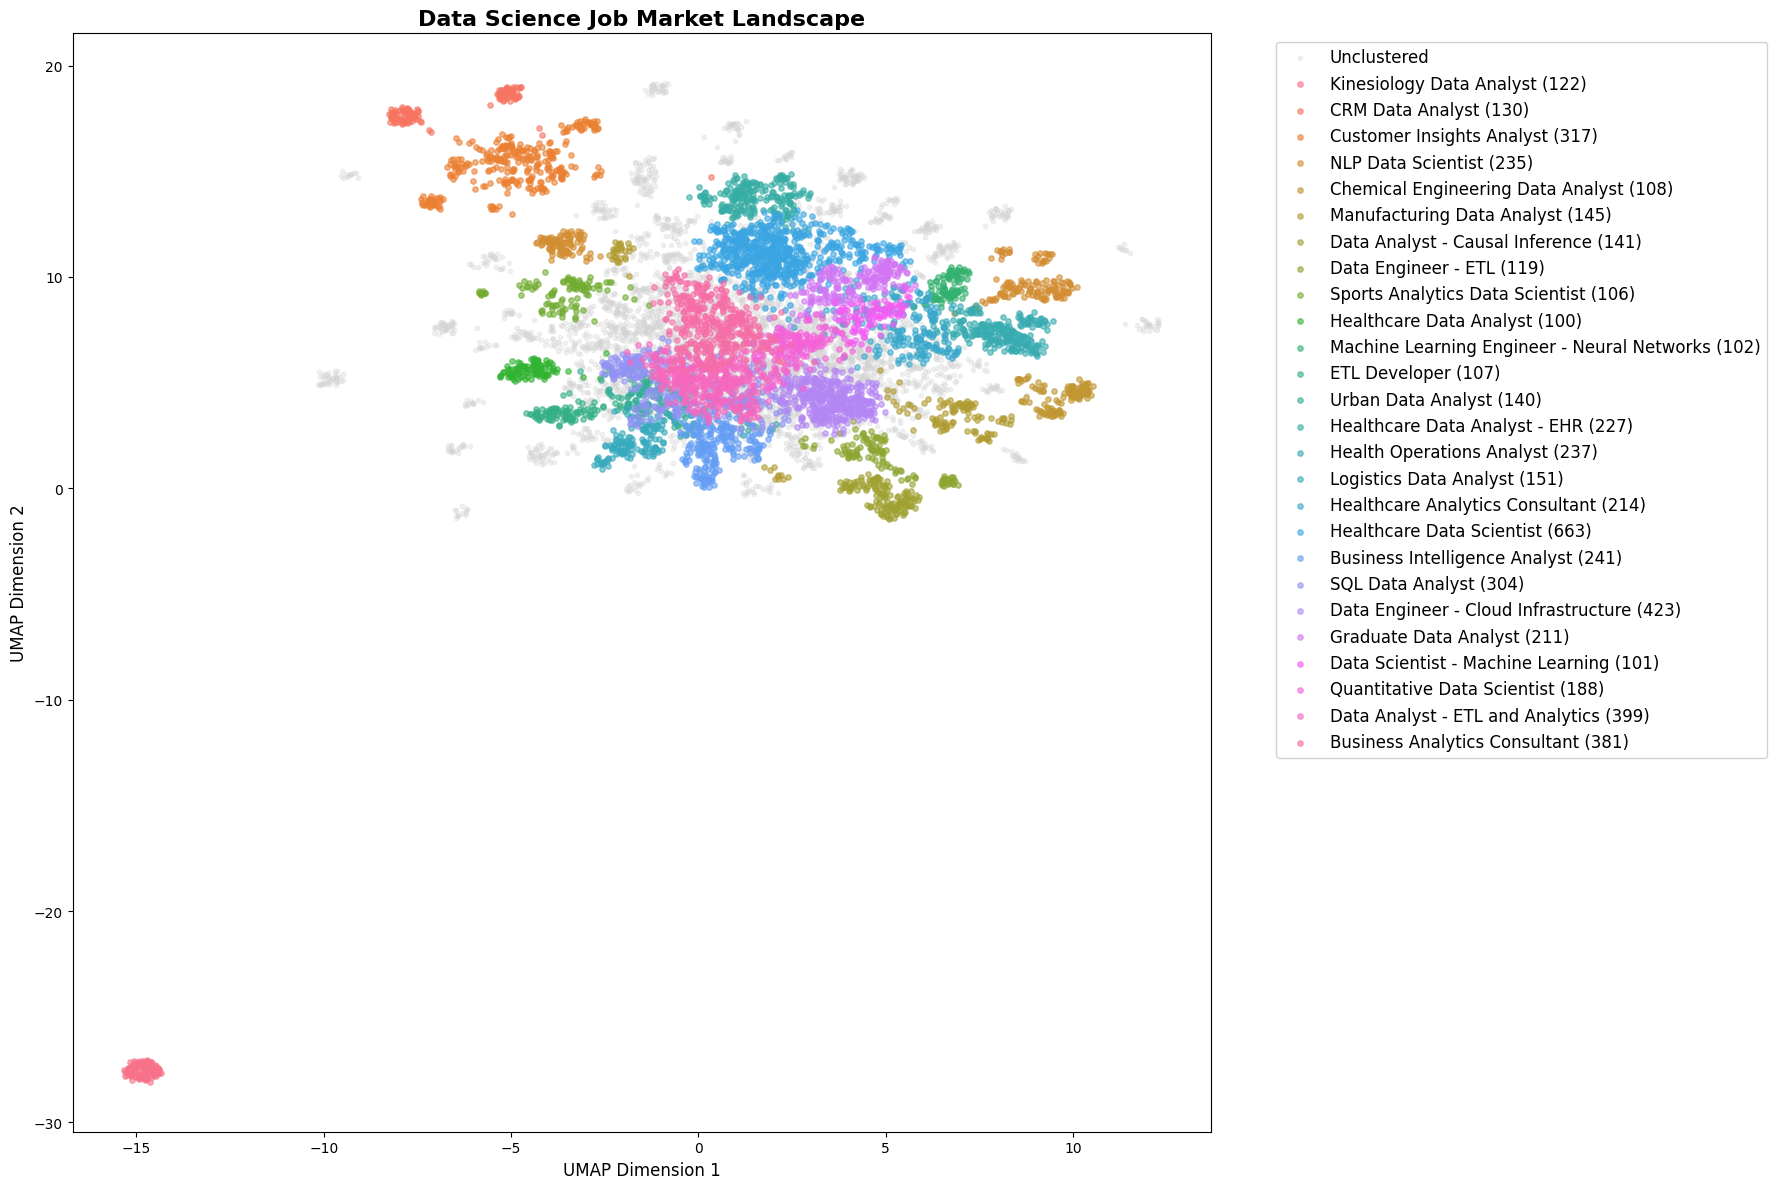


Distribution of Cluster size
cluster_name
Unclustered                                    3824
Healthcare Data Scientist                       663
Data Engineer - Cloud Infrastructure            423
Data Analyst - ETL and Analytics                399
Business Analytics Consultant                   381
Customer Insights Analyst                       317
SQL Data Analyst                                304
Business Intelligence Analyst                   241
Health Operations Analyst                       237
NLP Data Scientist                              235
Healthcare Data Analyst - EHR                   227
Healthcare Analytics Consultant                 214
Graduate Data Analyst                           211
Quantitative Data Scientist                     188
Logistics Data Analyst                          151
Manufacturing Data Analyst                      145
Data Analyst - Causal Inference                 141
Urban Data Analyst                              140
CRM Data Analyst     

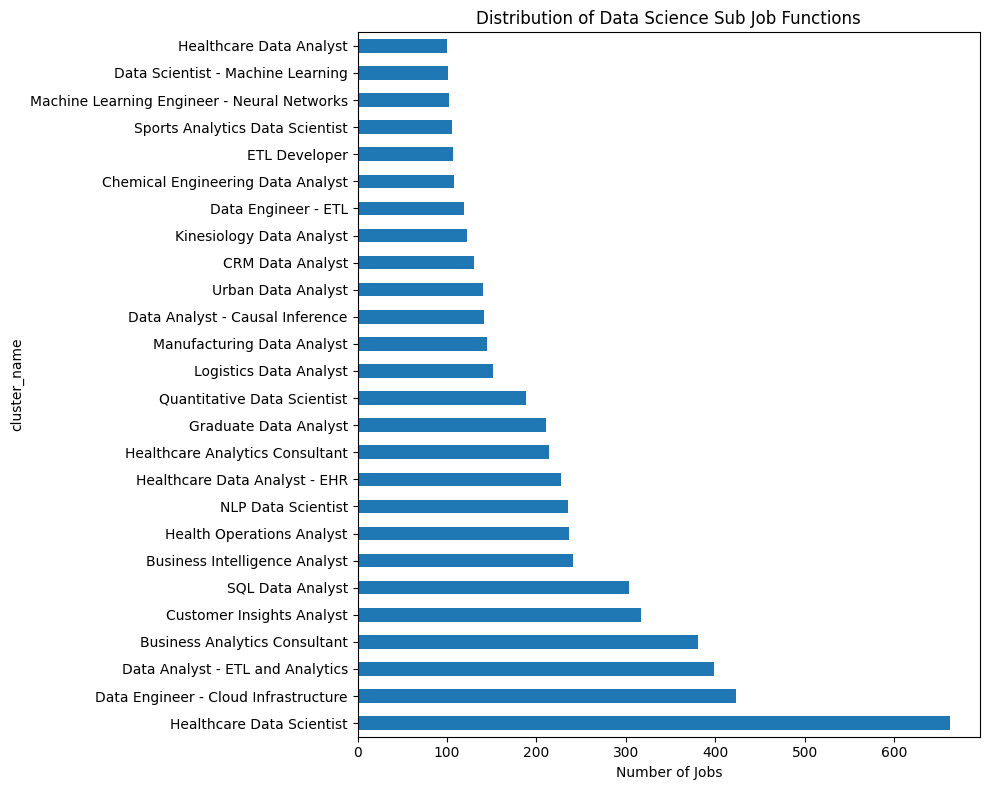

In [37]:
df_filtered['cluster'] = cluster_labels
df_filtered['cluster_name'] = df_filtered['cluster'].map(cluster_names)
df_filtered['cluster_name'] = df_filtered['cluster_name'].fillna('Unclustered')

# create a colored 2D visualization
plt.figure(figsize=(18, 12))

# plot noisy data points as grey backgrounds
noise_mask = cluster_labels == -1
if noise_mask.any():
    plt.scatter(embeddings_2d[noise_mask, 0], embeddings_2d[noise_mask, 1],
                s=10, alpha=0.3, c='lightgray', label='Unclustered')

# plot each cluster with a different color
n_clusters = len(cluster_names)
colors = sns.color_palette("husl", n_clusters)

for idx, (cluster_id, name) in enumerate(sorted(cluster_names.items())):
    mask = cluster_labels == cluster_id
    plt.scatter(embeddings_2d[mask, 0], embeddings_2d[mask, 1],
                s=15, alpha=0.6, c=[colors[idx]], label=f"{name} ({mask.sum()})")

plt.title("Data Science Job Market Landscape", fontsize=16, fontweight='bold')
plt.xlabel("UMAP Dimension 1", fontsize=12)
plt.ylabel("UMAP Dimension 2", fontsize=12)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12, framealpha=0.9)
plt.tight_layout()
plt.show()

# show cluster size distribution
print("\nDistribution of Cluster size")
cluster_counts = df_filtered['cluster_name'].value_counts()
print(cluster_counts)

# visualize cluster sizes as a bar chart
plt.figure(figsize=(10, 8))
cluster_counts[cluster_counts.index != 'Unclustered'].plot(kind='barh')
plt.xlabel("Number of Jobs")
plt.title("Distribution of Data Science Sub Job Functions")
plt.tight_layout()
plt.show()

- Visualize and understand the clusters better with plotly

In [38]:
import plotly.express as px

plot_df = pd.DataFrame({
    'UMAP1': embeddings_2d[:, 0],
    'UMAP2': embeddings_2d[:, 1],
    'Cluster': df_filtered['cluster_name'].values,
    'Job Title': df_filtered['job_title'].values,
    'Cluster_ID': cluster_labels
})

fig = px.scatter(
    plot_df[plot_df['Cluster'] != 'Unclustered'],
    x='UMAP1',
    y='UMAP2',
    color='Cluster',
    hover_data=['Job Title'],
    title='Data Science Job Market Landscape (Interactive)',
    width=1200,
    height=800,
    color_discrete_sequence=px.colors.qualitative.Alphabet
)

fig.update_traces(marker=dict(size=5, opacity=0.7))
fig.update_layout(legend=dict(yanchor="top", y=0.99, xanchor="left", x=1.01))
fig.show()